In [2]:
from rdkit import Chem
from rdkit.Chem import rdchem
from rdkit.Chem import Lipinski
from collections import defaultdict

# from molecules.fragmentation import reconstruct
from rdkit import Chem
import numpy as np
from rdkit.Chem import BRICS
from copy import deepcopy

dummy = Chem.MolFromSmiles('[*]')

def mol_from_smiles(smi):
    smi = canonicalize(smi)
    return Chem.MolFromSmiles(smi)

def strip_dummy_atoms(mol):
    hydrogen = mol_from_smiles('[H]')
    mols = Chem.ReplaceSubstructs(mol, dummy, hydrogen, replaceAll=True)
    mol = Chem.RemoveHs(mols[0])
    return mol

def break_on_bond(mol, bond, min_length=3):
    if mol.GetNumAtoms() - bond <= min_length:
        return [mol]

    broken = Chem.FragmentOnBonds(
        mol, bondIndices=[bond],
        dummyLabels=[(0, 0)])

    res = Chem.GetMolFrags(
        broken, asMols=True, sanitizeFrags=False)

    return res

def get_size(frag):
    dummies = count_dummies(frag)
    total_atoms = frag.GetNumAtoms()
    real_atoms = total_atoms - dummies
    return real_atoms


def count_dummies(mol):
    count = 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() == 0:
            count += 1
    return count

def mol_to_smiles(mol):
    smi = Chem.MolToSmiles(mol, isomericSmiles=True)
    return canonicalize(smi)


def mols_to_smiles(mols):
    return [mol_to_smiles(m) for m in mols]
    #return [Chem.MolToSmiles(m, isomericSmiles=True, allBondsExplicit=True) for m in mols]


def canonicalize(smi, clear_stereo=False):
    mol = Chem.MolFromSmiles(smi)
    if clear_stereo:
        Chem.RemoveStereochemistry(mol)
    return Chem.MolToSmiles(mol, isomericSmiles=True)


def fragment_recursive(mol, frags):
    try:
        bonds = list(BRICS.FindBRICSBonds(mol))

        if bonds == []:
            frags.append(mol)
            return frags

        idxs, labs = list(zip(*bonds))

        bond_idxs = []
        for a1, a2 in idxs:
            bond = mol.GetBondBetweenAtoms(a1, a2)
            bond_idxs.append(bond.GetIdx())

        order = np.argsort(bond_idxs).tolist()
        bond_idxs = [bond_idxs[i] for i in order]

        # 只会断开一根键，也就是说，如果某个片段可以切割两个断点，但是只会切割其中一个，另一个会跟该变短视作一个整体
        broken = Chem.FragmentOnBonds(mol,
                                      bondIndices=[bond_idxs[0]], 
                                      dummyLabels=[(0, 0)])
        head, tail = Chem.GetMolFrags(broken, asMols=True)
        # print(mol_to_smiles(head), mol_to_smiles(tail))
        frags.append(head)
        return fragment_recursive(tail, frags)
    except Exception:
        pass

def join_molecules(molA, molB):
    marked, neigh = None, None
    for atom in molA.GetAtoms():
        if atom.GetAtomicNum() == 0:
            marked = atom.GetIdx()
            neigh = atom.GetNeighbors()[0]
            break
    neigh = 0 if neigh is None else neigh.GetIdx()

    if marked is not None:
        ed = Chem.EditableMol(molA)
        if neigh > marked:
            neigh = neigh - 1
        ed.RemoveAtom(marked)
        molA = ed.GetMol()

    joined = Chem.ReplaceSubstructs(
        molB, dummy, molA,
        replacementConnectionPoint=neigh,
        useChirality=False)[0]

    Chem.Kekulize(joined)
    return joined

def reconstruct(frags, reverse=False):
    if len(frags) == 1:
        return strip_dummy_atoms(frags[0]), frags

    if count_dummies(frags[0]) != 1:
        return None, None

    if count_dummies(frags[-1]) != 1:
        return None, None

    for frag in frags[1:-1]:
        if count_dummies(frag) != 2:
            return None, None
    
    mol = join_molecules(frags[0], frags[1])
    for i, frag in enumerate(frags[2:]):
        #print(i, mol_to_smiles(frag), mol_to_smiles(mol))
        mol = join_molecules(mol, frag)
        #print(i, mol_to_smiles(mol))

    # see if there are kekulization/valence errors
    mol_to_smiles(mol)

    return mol, frags
        
def break_into_fragments(mol, smi):
    frags = []
    frags = fragment_recursive(mol, frags)

    if len(frags) == 0:
        return smi, np.nan, 0

    if len(frags) == 1:
        return smi, smi, 1

    rec, frags = reconstruct(frags)
    if rec and mol_to_smiles(rec) == smi:
        # fragments = [Chem.MolToSmiles(frag, isomericSmiles=True, canonical=False) for frag in frags]
        fragments = mols_to_smiles(frags)
        return smi, " ".join(fragments), len(frags),frags

    return smi, np.nan, 0



N=[N+]=[N+]=C(Cc1ccc2ccccc2c1)[N+](=O)[O-]


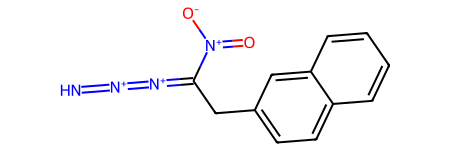

In [19]:
smiles = "N=[N+]=[N+]=C(Cc1ccc2ccccc2c1)[N+](=O)[O-]"  # 输入SMILES
smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles))  # 标准化SMILES
mol = Chem.MolFromSmiles(smiles)
print(smiles)
mol

In [20]:
result = break_into_fragments(mol, smiles)
result

('N=[N+]=[N+]=C(Cc1ccc2ccccc2c1)[N+](=O)[O-]',
 '*CC(=[N+]=[N+]=N)[N+](=O)[O-] *c1ccc2ccccc2c1',
 2,
  <rdkit.Chem.rdchem.Mol at 0x7ff3ac595f20>])

In [12]:
result[0]

'N=[N+]=[N+]=C(Cc1ccc2ccccc2c1)[N+](=O)[O-]'

In [13]:
result[1]

'*CC(=[N+]=[N+]=N)[N+](=O)[O-] *c1ccc2ccccc2c1'

In [14]:
len(result[1])

45

In [15]:
len(result[0])

42

In [21]:
'[BOS]' + result[1].replace(' ', '[SEP]') + '[EOS]'

'[BOS]*CC(=[N+]=[N+]=N)[N+](=O)[O-][SEP]*c1ccc2ccccc2c1[EOS]'